## Data Science Project: Analyzing COVID-19 Cases in Toronto

### Dataset Description: 

The primary dataset contains demographic, geographic, and severity information for all confirmed and probable cases reported to and managed by Toronto Public Health since the first case reported in January 2020.
 - Includes cases that are sporadic (occurring in the community) and outbreak-associated.
 - Data are extracted from provincial communicable disease reporting system (iPHIS) and Toronto's custom COVID-19 case management system (CORES). 
 - Link: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

The Census 2016 dataset is a secondary dataset that is used to support in answering questions that pertain to the primary dataset. 
 
### Insights that can be drawn from this dataset by asking questions:
(Format: question to be asked, and an explanation of its business case impact.
 - ✅ What is the age group that has been most affected? 
   - To obtain a better understanding of which age group is most vulnerable, and which age group has been affected the least. A public warning can be given to better inform others and help them in becoming more sensitive to those who are most vulnerable.
 - 🟧 Visual map showcasing number of cases in each neighbourhood - Not possible to get postal code map since Canada Post bought rights to it. There is actually an alternative: Area Codes are made available as showcased in 'Analyzing Toronto Housing Market'.
 - ✅Which neighborhood has been most affected? Showcase the progression over time on a multiple-line plot 
   - We want to know which neighbourhood is driving the case numbers in Toronto.
   - People can be better informed and even warned to avoid visiting the top 10 most infected neighbourhoods
   - The COVID19 response team can form a more effective response plan, focused on curbing the rise of cases within those neighbourhoods
 - ✅ Case progression in Toronto over time. 
   - Noting if there were spikes at any point in time that took place between the start of COVID and the current time.
 - ✅ Source of infection: Which source is contributing the most to Canada's COVID-19 cases?  
   - Better understand where most of COVID19 reported cases are coming from: is it from travel? Hospital visits? Community transmission?
   - To inform the public to avoid activities that have the highest percentage of driving case rates.
   - To guide the COVID19 response team in enacting effective policies that discourage others from engaging in said activities (travel, gatherings, etc.)
 - ✅ How many confirmed cases? How many probable cases? 
 - ✅ What are the average duration between Episode Date and Reported Date? (time between when disease was acquired to the symptom onset/lab specimen collection date/ reported date. 
   - To gain an understanding of the duration between the individual's COVID19 contraction date and the date at which they are deemed to be positive.
 - ✅ How many cases are currently still active? 

In [1]:
import pandas as pds
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np

In [2]:
# Dataset import github repository
df = pds.read_csv('https://raw.githubusercontent.com/KevinRiady/COVID19-Toronto-Data-Project/master/Datasets/covid-19-cases-in-toronto.csv')

In [25]:
# Making sense of the dataset
print(df.head(5))
print("---")
print(df.info())

     _id  Assigned_ID Outbreak Associated       Age Group  \
0  46311            1            Sporadic  50 to 59 Years   
1  46312            2            Sporadic  50 to 59 Years   
2  46313            3            Sporadic  20 to 29 Years   
3  46314            4            Sporadic  60 to 69 Years   
4  46315            5            Sporadic  60 to 69 Years   

      Neighbourhood Name  FSA Source of Infection Classification Episode Date  \
0        Willowdale East  M2N              Travel      CONFIRMED   2020-01-22   
1        Willowdale East  M2N              Travel      CONFIRMED   2020-01-21   
2      Parkwoods-Donalda  M3A              Travel      CONFIRMED   2020-02-05   
3  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-16   
4  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-20   

  Reported Date Client Gender   Outcome Currently Hospitalized  \
0    2020-01-23        FEMALE  RESOLVED                     No   
1    2020-01-2

In [4]:
print(df.shape)
# Total number of cases: 15,644

# Automate for flexibility (in expectation for live connection to dataset)
totalCases = len(df.index)
print(totalCases)

(15644, 18)
15644


In [5]:
df['Classification'].value_counts()

CONFIRMED    14387
PROBABLE      1257
Name: Classification, dtype: int64

In [6]:
# Since we have column names here, we'll dedicate this space to setting up
# the different dataframes we'll be using in this project.
neighbourhood_infections = df[['Neighbourhood Name', 'FSA', 'Classification',
                             'Episode Date', 'Reported Date', 'Outcome']]
neighbourhood_infections

# Another dataframe to research the main sources of COVID19 cases in the city
sourceOfInfection = df[['Source of Infection', 'Reported Date']]

# Analyzing duration between episode date and reported date
lagTime = df[['Episode Date', 'Reported Date']]

### What age group has been most affected by this pandemic?

In [7]:
# Find out how ages has been grouped in this dataset.
age_group = df['Age Group'].unique()
age_group

array(['50 to 59 Years', '20 to 29 Years', '60 to 69 Years',
       '80 to 89 Years', '70 to 79 Years', '30 to 39 Years',
       '40 to 49 Years', '19 and younger', nan, '90 and older'],
      dtype=object)

In [8]:
# Total population of each age group

# By using .value_counts method, we can quickly discover which age group has been impacted the most.

countsByAgeGroup = df['Age Group'].value_counts(ascending=False).rename_axis('Age Group').reset_index(name='counts')
countsByAgeGroup
new_index = [8, 1, 2, 3, 0, 4, 7, 5, 6]
countsByAgeGroup = countsByAgeGroup.reindex(new_index)
countsByAgeGroup

,Age Group,counts
8,19 and younger,1024
1,20 to 29 Years,2297
2,30 to 39 Years,2251
3,40 to 49 Years,2182
0,50 to 59 Years,2467
4,60 to 69 Years,1671
7,70 to 79 Years,1075
5,80 to 89 Years,1542
6,90 and older,1109


Order of age group with the most to least number of cases: 50 to 59 > 20 to 29 > 30 to 39 > 40 to 49 > 60 - 69 > 80 - 89 > 19 and younger is the lowest.

Begging question: how many % do these numbers make up out of the total population in these age groups? 

To answer, we need to find another dataset. Since our dataset focuses on Toronto, we only want the census as it pertains to this city.

In [26]:
# Let's import the 2016 Canadian Census
url = 'https://raw.githubusercontent.com/KevinRiady/COVID19-Toronto-Data-Project/master/Datasets/canada-census-2016.csv'
census2016 = pds.read_csv(url)
census2016.head(5)

,CENSUS_YEAR,GEO_CODE (POR),GEO_LEVEL,GEO_NAME,GNR,DATA_QUALITY_FLAG,ALT_GEO_CODE,DIM: Census year (2),Member ID: Census year (2),Notes: Census year (2),DIM: Age (in single years) and average age (127),Member ID: Age (in single years) and average age (127),Notes: Age (in single years) and average age (127),Dim: Sex (3): Member ID: [1]: Total - Sex,Dim: Sex (3): Member ID: [2]: Male,Dim: Sex (3): Member ID: [3]: Female
0,2016,1,0,Canada,4.0,20000,1,2016,1,NaN,Total - Age,1,NaN,35151725.0,17264200.0,17887530.0
1,2016,1,0,Canada,4.0,20000,1,2016,1,NaN,0 to 14 years,2,NaN,5839565.0,2992920.0,2846645.0
2,2016,1,0,Canada,4.0,20000,1,2016,1,NaN,0 to 4 years,3,NaN,1898790.0,973035.0,925760.0
3,2016,1,0,Canada,4.0,20000,1,2016,1,NaN,Under 1 year,4,NaN,369730.0,189085.0,180650.0
4,2016,1,0,Canada,4.0,20000,1,2016,1,NaN,1,5,NaN,372615.0,190900.0,181710.0


In [10]:
# We only want the data for Toronto gathered in 2016 census.
censusToronto = census2016[(census2016['GEO_NAME'] == 'Toronto') & (census2016['DIM: Census year (2)'] == 2016)]
censusToronto.dtypes

CENSUS_YEAR                                                 int64
GEO_CODE (POR)                                              int64
GEO_LEVEL                                                   int64
GEO_NAME                                                   object
GNR                                                       float64
DATA_QUALITY_FLAG                                           int64
ALT_GEO_CODE                                                int64
DIM: Census year (2)                                        int64
Member ID: Census year (2)                                  int64
Notes: Census year (2)                                    float64
DIM: Age (in single years) and average age (127)           object
Member ID: Age (in single years) and average age (127)      int64
Notes: Age (in single years) and average age (127)        float64
Dim: Sex (3): Member ID: [1]: Total - Sex                 float64
Dim: Sex (3): Member ID: [2]: Male                        float64
Dim: Sex (

In [11]:
# Extracting data for 1) the age groups, and 2) the total number of people belonging to each age group
TorontoByAge = censusToronto[['DIM: Age (in single years) and average age (127)', 'Dim: Sex (3): Member ID: [1]: Total - Sex']]
TorontoByAge = TorontoByAge[pds.to_numeric(TorontoByAge['DIM: Age (in single years) and average age (127)'], errors='coerce').notnull()]
TorontoByAge['DIM: Age (in single years) and average age (127)'] = TorontoByAge['DIM: Age (in single years) and average age (127)'].astype(str).astype(int)
TorontoByAge.dtypes
# Now we need to somehow manipulate this such that it fits to the COVID-19 dataset age grouping.

DIM: Age (in single years) and average age (127)      int32
Dim: Sex (3): Member ID: [1]: Total - Sex           float64
dtype: object

In [12]:
# Aim: to group our census based on this 
# '50 to 59 Years', '20 to 29 Years', '60 to 69 Years',
# '80 to 89 Years', '70 to 79 Years', '30 to 39 Years',
# '40 to 49 Years', '19 and younger', nan, '90 and older'
start = [1, 20, 30, 40, 50, 60, 70, 80, 90]
end = [19, 29, 39, 49, 59, 69, 79, 89, 150]
TorontoByAgeList = []

# Loop's purpose: To obtain the total number of people belonging to each age group.
# E.g. when s = 1 and e = 19, all who are aged between 1 and 19 are summed, and the total for that age group is returned.
for (s, e) in zip(start, end):
    TorontoByAgeList.append(TorontoByAge[(TorontoByAge['DIM: Age (in single years) and average age (127)'] > s ) & (TorontoByAge['DIM: Age (in single years) and average age (127)'] < e) ].sum()['Dim: Sex (3): Member ID: [1]: Total - Sex'])

TorontoByAgeList # this is also the current demographic in Toronto.

[1154235.0,
 671380.0,
 661485.0,
 686275.0,
 701335.0,
 486875.0,
 278015.0,
 148510.0,
 31805.0]

In [27]:
# sanity check: 
print(TorontoByAge.head(5))
print("---")
print(TorontoByAge[(TorontoByAge['DIM: Age (in single years) and average age (127)'] == 1 )])
print(TorontoByAge[(TorontoByAge['DIM: Age (in single years) and average age (127)'] == 99 )])

       DIM: Age (in single years) and average age (127)  \
19308                                                 1   
19309                                                 2   
19310                                                 3   
19311                                                 4   
19313                                                 5   

       Dim: Sex (3): Member ID: [1]: Total - Sex  
19308                                    60165.0  
19309                                    61580.0  
19310                                    63995.0  
19311                                    64585.0  
19313                                    65250.0  
---
       DIM: Age (in single years) and average age (127)  \
19308                                                 1   

       Dim: Sex (3): Member ID: [1]: Total - Sex  
19308                                    60165.0  
       DIM: Age (in single years) and average age (127)  \
19428                                                99

In [14]:
# So let's go back to the % population affected by COVID-19 in Toronto by age group. Show it in a pie chart.
# First, convert the data frame of unique value counts of COVID-19 cases by age, countsByAgeGroup, into lists.
# Let's go back up to reindex the dataframe since it's easier than to reindex a list.
countsByAgeGroupList = countsByAgeGroup.values.tolist()
countsByAgeGroupList
percentAffected = []
print("% affected in Toronto grouped by Age")

# First method:
# for x in range(8):
#     print(countsByAgeGroupList[x][0], ":", (1 - ((TorontoByAgeList[x] - countsByAgeGroupList[x][1])
#                 /TorontoByAgeList[x]))*100, "%")

# Second method:
# By appending, we run the loop once to both 1) store the data, and 2) print the result in readable format (string)
for x in range(8):
    percentAffected.append((1 - ((TorontoByAgeList[x] - countsByAgeGroupList[x][1])
                /TorontoByAgeList[x]))*100)
    print("{}: {}%".format(countsByAgeGroupList[x][0], percentAffected[x]))

% affected in Toronto grouped by Age
19 and younger: 0.0887167691154711%
20 to 29 Years: 0.34213113289046637%
30 to 39 Years: 0.3402949424401114%
40 to 49 Years: 0.3179483443226161%
50 to 59 Years: 0.35175771920694654%
60 to 69 Years: 0.3432092426187472%
70 to 79 Years: 0.3866697840044564%
80 to 89 Years: 1.038313918254663%


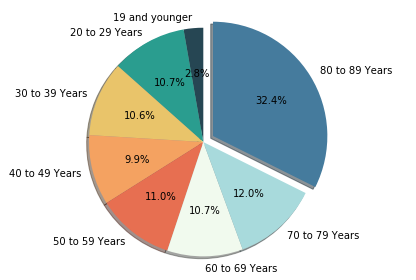

In [15]:
# Let's put this into a pie chart. 
labels = []

for x in range(8):
    labels.append(countsByAgeGroupList[x][0])
    
labels
explode = (0, 0, 0, 0, 0, 0, 0, 0.1)
colors = ['#264653', 
          '#2A9D8F', 
          '#E9C46A', 
          '#F4A261', 
          '#E76F51', 
          '#f1faee', 
          '#a8dadc', 
          '#457b9d']

fig1, ax1 = plt.subplots()
ax1.pie(percentAffected, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()

### Map of COVID19 progression in various neighbourhoods within the city.

Update: Canada Post has acquired Canadian Postal Codes to be a product to purchase. Thus, we cannot create a map here based on postal code locations. Other alternatives can be thought of.

Possibility! Area codes are available - this was used in the analysis of Toronto Housing. To be implemented.

### COVID19 Case Progression Within Each Neighbourhood

In [29]:
# Let's get the unique neighbourhood names first and their counts.
print(df['Neighbourhood Name'].unique())
print('---')
print(df['Neighbourhood Name'].value_counts().head(5))
top10Neighbourhoods = df.groupby(['Neighbourhood Name'], as_index=False)['Classification'].count()
top10Neighbourhoods = top10Neighbourhoods.sort_values(by='Classification', ascending=False).head(10)
print('---')
top10Neighbourhoods = top10Neighbourhoods['Neighbourhood Name'].tolist()
print(top10Neighbourhoods)

['Willowdale East' 'Parkwoods-Donalda' 'Church-Yonge Corridor'
 'Newtonbrook West' 'Milliken' 'Willowdale West' 'Henry Farm'
 'Don Valley Village' 'Lawrence Park South'
 'Bridle Path-Sunnybrook-York Mills' 'Moss Park' 'Annex'
 'Westminster-Branson' 'Leaside-Bennington' nan 'St.Andrew-Windfields'
 'Malvern' 'Bedford Park-Nortown' 'High Park North'
 'Waterfront Communities-The Island' 'Mimico (includes Humber Bay Shores)'
 'Danforth-East York' 'Princess-Rosethorn' 'Roncesvalles' 'Long Branch'
 'Dovercourt-Wallace Emerson-Junction' 'Mount Pleasant West'
 'Oakwood Village' 'South Parkdale' 'Mount Pleasant East'
 'North Riverdale' 'Eringate-Centennial-West Deane'
 'Palmerston-Little Italy' 'Stonegate-Queensway' 'Rouge'
 'Agincourt South-Malvern West' 'Englemount-Lawrence' 'Forest Hill North'
 'New Toronto' 'West Humber-Clairville' 'Casa Loma' 'Niagara'
 'High Park-Swansea' 'Downsview-Roding-CFB' 'Kensington-Chinatown'
 'Trinity-Bellwoods' 'Kennedy Park' 'Victoria Village' 'The Beaches'
 'Wo

In [30]:
# Choose rows that only contain the top 10 most infected neighbourhoods
neighbourhood_infections
top10NeighbourhoodsInfected = neighbourhood_infections[neighbourhood_infections['Neighbourhood Name'].isin(top10Neighbourhoods)]
# print(top10NeighbourhoodsInfected)

# Cumulative count
# top10NeighbourhoodsInfected.sort_values(by='Episode Date', ascending=True).groupby('Neighbourhood Name').cumcount()
cumulSum = top10NeighbourhoodsInfected.sort_values(by='Episode Date', ascending=True)
# Copying for later use in making line graph of overall progression over time
overallProg = cumulSum.copy()
for x in top10Neighbourhoods:
    cumulSum[x] = (cumulSum['Neighbourhood Name'] == x)
    cumulSum[x] = cumulSum[x].cumsum()
cumulSum = cumulSum.drop(columns=['Neighbourhood Name', 'FSA', 'Classification', 'Reported Date', 'Outcome'])
cumulSum.head(5)

,Episode Date,Glenfield-Jane Heights,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Downsview-Roding-CFB,York University Heights,Islington-City Centre West,Weston,Woburn,Rouge,Black Creek
2701,2020-03-03,0,0,0,0,0,1,0,0,0,0
67,2020-03-04,0,1,0,0,0,1,0,0,0,0
240,2020-03-05,0,1,0,0,0,1,0,1,0,0
58,2020-03-08,0,1,0,0,0,1,0,1,1,0
2142,2020-03-08,0,1,0,1,0,1,0,1,1,0


C:\Anaconda\envs\Python35\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, 'Number of Cases')

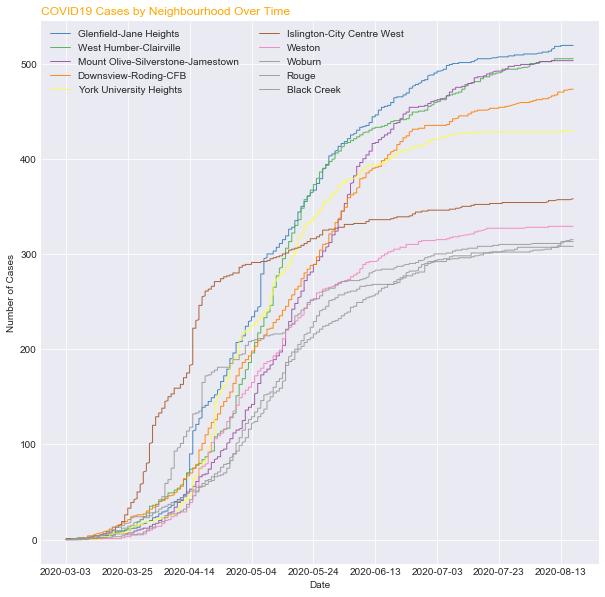

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
plt.figure(figsize=(10,10))
tick_spacing = 20
for column in cumulSum.drop('Episode Date', axis=1):
    num+=1
    plt.plot(cumulSum['Episode Date'], cumulSum[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

plt.legend(loc=2, ncol=2)
plt.title("COVID19 Cases by Neighbourhood Over Time", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Date")
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.ylabel("Number of Cases")

### COVID19 Case Progression of the Whole Toronto

Text(0.5, 1.0, 'Progression of COVID19 Cases in Toronto from Beginning to Present Time')

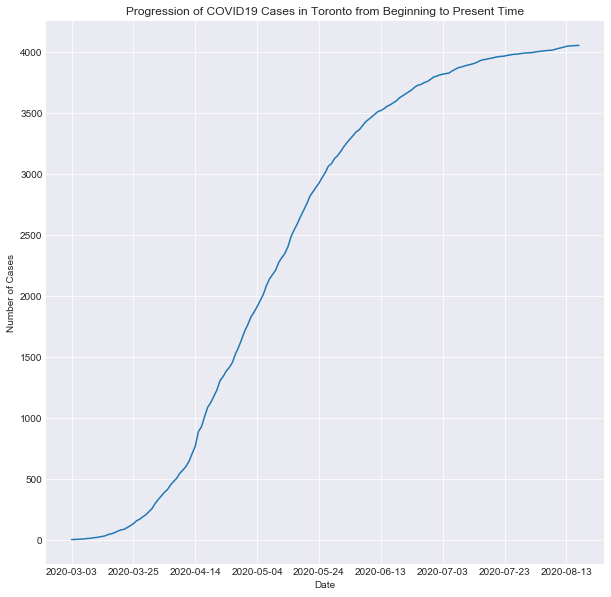

In [19]:
overallProg['Flag'] = 1
overallProgPlot = overallProg.groupby(by=['Episode Date'])['Flag'].sum().cumsum()
plt.figure(figsize=(10,10))
tick_spacing = 20
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.plot(overallProgPlot)
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("Progression of COVID19 Cases in Toronto from Beginning to Present Time")

### Finding the Source of Infection that is Driving the Case Numbers

In [20]:
sourceOfInfectionByGroup = sourceOfInfection.groupby(by='Source of Infection', as_index=False).count()
print(sourceOfInfectionByGroup)
print('---')
# Why is there a data discrepancy (in numbers) with Age Group being the odd one out?
bySource = sourceOfInfectionByGroup['Source of Infection']
percentBySource = []

print("% of total cases by Source of Infection\n")
for x in range(8):
    percentBySource.append((float(sourceOfInfectionByGroup.iloc[x][1])/float(totalCases))*100)
    print("{}: {} %".format(sourceOfInfectionByGroup.iloc[x][0], percentBySource[x]))

         Source of Infection  Reported Date
0              Close contact           5282
1                  Community           2172
2                 Healthcare            954
3              Institutional            321
4  N/A - Outbreak associated           5814
5                    Pending             95
6                     Travel            624
7            Unknown/Missing            382
---
% of total cases by Source of Infection

Close contact: 33.7637432881616 %
Community: 13.883917156737407 %
Healthcare: 6.0981846075172585 %
Institutional: 2.0519048836614675 %
N/A - Outbreak associated: 37.164408079774994 %
Pending: 0.6072615699309639 %
Travel: 3.988749680388647 %
Unknown/Missing: 2.4418307338276657 %


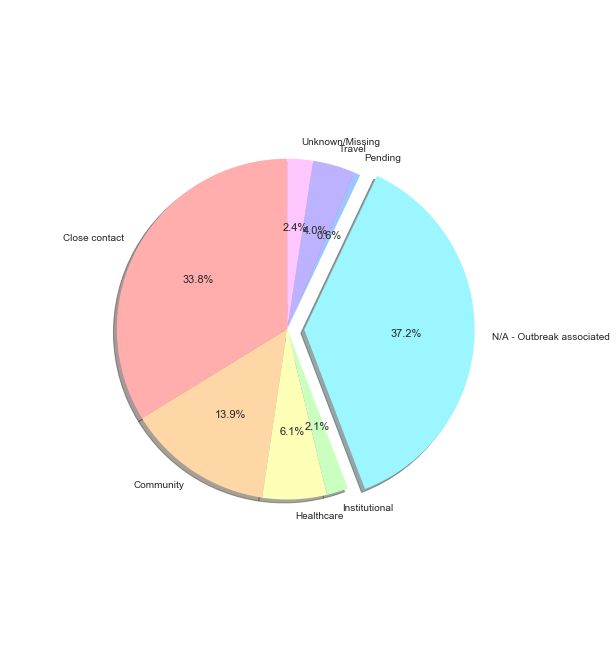

In [21]:
# Let's put this into a pie chart. 
explode = (0, 0, 0, 0, 0.1, 0, 0, 0)
colors = ['#ffadad', 
          '#ffd6a5', 
          '#fdffb6', 
          '#caffbf', 
          '#9bf6ff', 
          '#a0c4ff', 
          '#bdb2ff',
          '#ffc6ff']

fig1, ax1 = plt.subplots()
ax1.pie(percentBySource, explode=explode, labels=bySource, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=1, textprops={'fontsize': 11})
ax1.axis('equal')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

### Average Duration Between Episode Date and Reported Date

In [22]:
lagTime[['Episode Date', 'Reported Date']] = lagTime[['Episode Date', 'Reported Date']].apply(pds.to_datetime)
# lagTime['Episode Date'] = lagTime['Episode Date'].dt.date
# lagTime['Reported Date'] = lagTime['Reported Date'].dt.date
# lagTime['Episode Date'] = pds.to_datetime(lagTime['Episode Date'])
# lagTime['Reported Date'] = pds.to_datetime(lagTime['Reported Date'])
lagTime['Lag Time'] = lagTime['Reported Date'] - lagTime['Episode Date']
print(lagTime['Lag Time'].describe())
print("90th percentile of all cases are reported within {}".format(lagTime['Lag Time'].quantile(0.90)))

count                     15644
mean     6 days 03:20:45.410380
std      8 days 06:49:01.414793
min             0 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             7 days 00:00:00
max           130 days 00:00:00
Name: Lag Time, dtype: object
90th percentile of all cases are reported within 14 days 00:00:00


C:\Anaconda\envs\Python35\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Anaconda\envs\Python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Total Number of Cases that Remain Active

In [23]:
(df.Outcome == 'ACTIVE').sum()

270